In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 11 14:17:03 2024

@author: tower2
"""
from sklearn import metrics

import torch
import os
import random
from datetime import datetime
import numpy as np
from loadung_batches import PrepareDataloader
from loadung_batches import Dataloader
#from train import Training 
import copy
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from preprocess import preprocess_adj,get_feature, preprocess_adj_sparse, preprocess, construct_interaction, construct_interaction_KNN,construct_interaction_KNN_edge_index, fix_seed
from scipy.sparse import issparse
import torch.utils.data as data
from SGST import SGST

BASE_PATH = Path('/media/rokny/DATA1/Roxana/Data/Ankur/MS19/')
sample_name ='MS19_feature.h5ad'

spot_paths= Path(f'{BASE_PATH}/{sample_name}')


In [2]:
class Config(object): # we create a config class to include all paths and parameters 
    def __init__(self):
        self.use_cuda = True
        self.threads = 1
        self.device = torch.device('cuda:1')
        self.spot_paths = spot_paths# in spot_paths, there can be multiple paths and SGCAST will run on the data one by one
        self.nfeat = 50 # Training config
        self.nhid = 50
        self.nemb = 50
        self.batch_size = 3000  
        self.lr_start = 0.2 
        self.lr_times = 2
        self.lr_decay_epoch = 80 
        self.epochs_stage =200 
        self.seed = 12345
        self.dtype = 'Xenium'
        self.checkpoint = ''
        self.train_conexp_ratio = 0.07 
        self.train_conspa_ratio = 0.07
        self.test_conexp_ratio = 0.07 
        self.test_conspa_ratio = 0.07 


config = Config()
config_used = copy.copy(config)
torch.manual_seed(config_used.seed)
random.seed(config_used.seed)
np.random.seed(config_used.seed)
loader = PrepareDataloader(config)
train_loader, test_loader, num_iter,adata = loader.getloader()
print('batch size:', loader.batch_size)
print('number of batches:', num_iter)

Reading data type: Xenium
ST data shape: (316350, 319)
Reading data type: Xenium
ST data shape: (316350, 319)
sample_num : 316350
batch_size : 3000
batch size: 3000
number of batches: 106


In [3]:
import numpy as np

# Assuming `adata.X` contains the data you want to normalize
X = adata.X

if issparse(X):
    X = X.toarray()  # Convert sparse matrix to dense if necessary

# Apply Min-Max Normalization to each feature (gene)
min_vals = np.min(X, axis=0)
max_vals = np.max(X, axis=0)

# Avoid division by zero
ranges = max_vals - min_vals
ranges[ranges == 0] = 1  # To handle constant features

X_normalized = (X - min_vals) / ranges

# Update adata with normalized data
adata.X = X_normalized


In [6]:
model = SGST(adata,train_loader, test_loader,random_seed=config_used.seed,num_batch=num_iter, device=config_used.device,datatype=config_used.dtype)


Training start 
Begin to train ST data...
batch: 1/179
Graph constructed!


Training: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.13epoch/s]


Finish


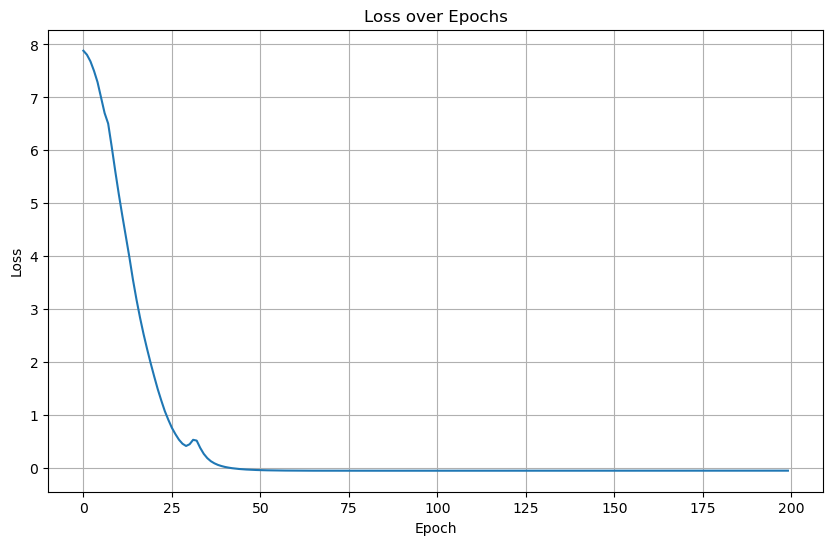

18218
Semantic Graph Learning Completed


Feature Learning Epochs:   4%|▋                | 24/600 [00:02<01:09,  8.29it/s]


KeyboardInterrupt: 

In [7]:
print('Training start ')

model.train()

In [11]:
adata=model.get_embedding()

Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constructed!
Graph constr

In [4]:
# clustering
n_clusters = 8

tool = 'mclust' # mclust, leiden, and louvain
seed=41
# clustering
from utils import clustering
if tool == 'mclust':
   clustering(adata,seed, n_clusters, method=tool,key='emb_decoder',refinement=False)
elif tool in ['leiden', 'louvain']:
   clustering(adata,seed, n_clusters, method=tool,key='emb_decoder', start=0.01, end=0.63, increment=0.01)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


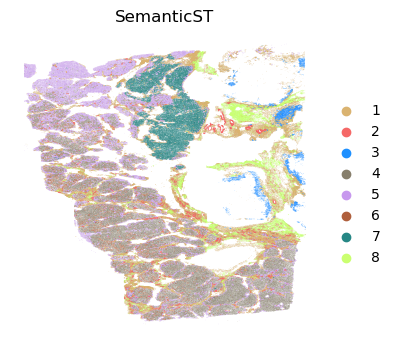

In [6]:
plt.rcParams["figure.figsize"] = (4,4)
plot_color=["#DAB370", "#F56867", "#1E90FF", "#877F6C", "#C798EE", "#AF5F3C",
            "#268785", "#CAFF70", "#556B2F", "#B22222", "#8B658B", "#59BE86", "#EE7621", 
            "#DB4C6C", "#8470FF", "#006400", "#82EF2D", "#FFD700", "#CD69C9", "#F9BD3F", "#B4EEB4", "#CD5555"]

adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]
sc.pl.embedding(adata, basis="spatial", color="domain",palette=plot_color, show=False, title="SemanticST")
plt.gca().invert_yaxis()  # This will invert the y-axis
plt.axis('off')
plt.savefig("SemanticST_8_NS26", dpi=300,bbox_inches='tight')
plt.show()


In [3]:
#np.save("domain_Xenium_mclust_24_MS19.npy",adata.obs['domain'])
#adata.obs['domain']=np.load("domain_Xenium_mclust_20_n26.npy")
adata.obs['domain']=np.load("domain_Xenium_mclust_21_MS19.npy")

In [4]:
#np.save("emb_Xenium_batch_n26.npy",adata.obsm['emb_decoder'])
adata.obsm['emb_decoder']=np.load("emb_Xenium_batch_n26.npy")

In [4]:
adata.obs['ground_truth']

aaaadkjh-1                    Hepatocyte
aaaagijo-1                    Hepatocyte
aaaajceb-1                         CD4 T
aaaakbjo-1                    Hepatocyte
aaaamafg-1                    Hepatocyte
                         ...            
oiklpbed-1                    Hepatocyte
oikmcmog-1                    Hepatocyte
oikmdfli-1    Noninflammatory Macrophage
oikmeoka-1                         CD4 T
oikmepmj-1                    Hepatocyte
Name: ground_truth, Length: 316350, dtype: category
Categories (21, object): ['B', 'CD4 T', 'CD8 T', 'Cholangiocyte', ..., 'Sinusoidal Endothelial', 'Vascual Central Venous Endothelial', 'Vascual Portal Endothelial', 'pDC']

In [5]:
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
adata

View of AnnData object with n_obs × n_vars = 316350 × 319
    obs: 'ground_truth', 'ground_truth_version2', 'n_counts', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'

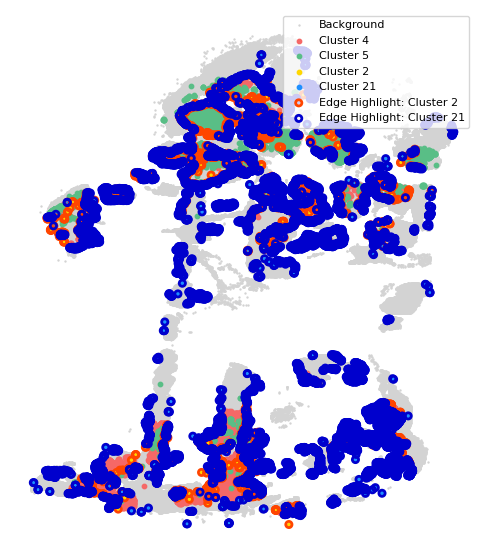

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.rcParams["figure.figsize"] = (6, 7)

# Base plot: All points in light gray
plt.scatter(
    adata.obsm['spatial'][:, 0], 
    adata.obsm['spatial'][:, 1], 
    c='lightgray', 
    s=0.5,  # Small size for background points
    label='Background'
)

# Highlight specific clusters with unique colors
highlight_colors = {
    "4": "#F56867",  # Red for cluster 4
    "5": "#59BE86",  # Green for cluster 5
    "2": "#FFD700",  # Yellow for cluster 2
    "21": "#1E90FF"  # Blue for cluster 21
}

# Plot highlighted clusters
for cluster_id, color in highlight_colors.items():
    # Filter coordinates for the specific cluster
    cluster_coords = adata.obsm['spatial'][np.where(adata.obs['domain'] == cluster_id)[0]]
    
    # Overlay the specific cluster
    plt.scatter(
        cluster_coords[:, 0], 
        cluster_coords[:, 1], 
        c=color, 
        s=10,  # Larger size for highlighted points
        label=f'Cluster {cluster_id}'
    )

# Add edge effects for clusters 2 and 21
for cluster_id, edge_color in zip(["2", "21"], ["#FF4500", "#0000CD"]):  # Orange and Dark Blue for edges
    cluster_coords = adata.obsm['spatial'][np.where(adata.obs['domain'] == cluster_id)[0]]
    plt.scatter(
        cluster_coords[:, 0],
        cluster_coords[:, 1],
        edgecolor=edge_color,
        linewidth=2,
        facecolors='none',
        s=10,  # Adjust size for emphasis
        label=f'Edge Highlight: Cluster {cluster_id}'
    )

# Invert Y-axis for correct spatial orientation
plt.gca().invert_yaxis()

# Remove axes for cleaner visualization
plt.axis('off')

# Add a legend
plt.legend(loc='upper right', fontsize=8)

# Save the plot
plt.savefig("Highlighted_Clusters_with_Background.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


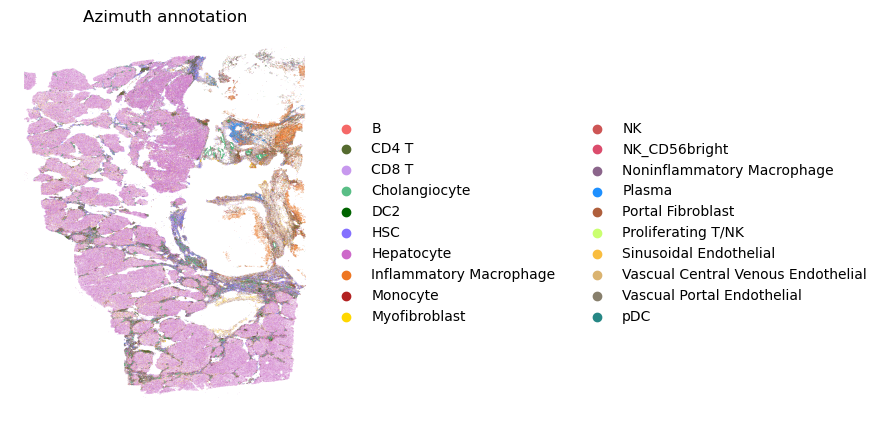

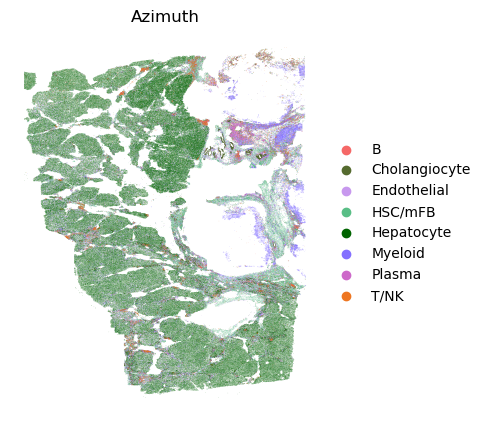

In [4]:
plt.rcParams["figure.figsize"] = (4,5)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
           "#877F6C","#268785", '#82EF2D', '#B4EEB4']
adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]

sc.pl.embedding(adata, basis="spatial", color="ground_truth",palette=plot_color, show=False, title='Azimuth annotation')
plt.gca().invert_yaxis()  # This will invert the y-axis
plt.axis('off')
plt.savefig("Xenium_NS26_pred1.png", dpi=300,bbox_inches='tight')
plt.show()
plt.rcParams["figure.figsize"] = (4,5)
sc.pl.embedding(adata, basis="spatial", color="ground_truth_version2",palette=plot_color, show=False, title='Azimuth')
plt.gca().invert_yaxis()  # This will invert the y-axis
plt.axis('off')
plt.savefig("Xenium_NS26_pred2.png", dpi=300,bbox_inches='tight')
plt.show()

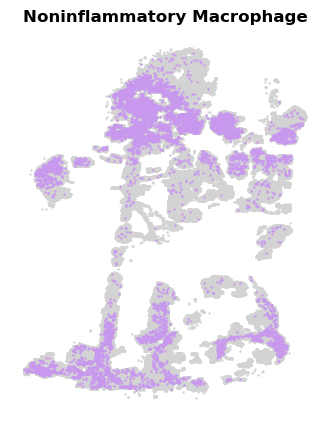

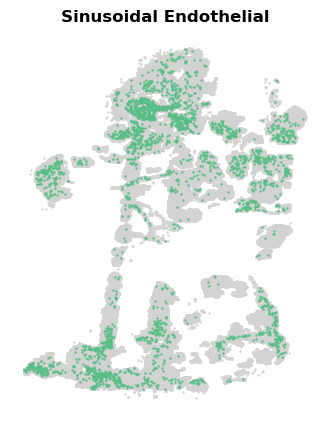

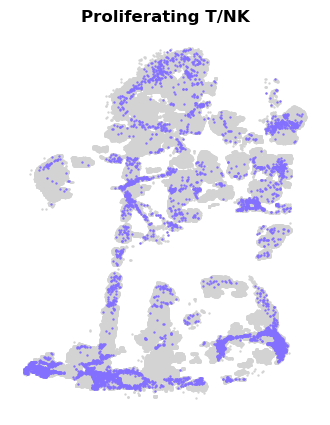

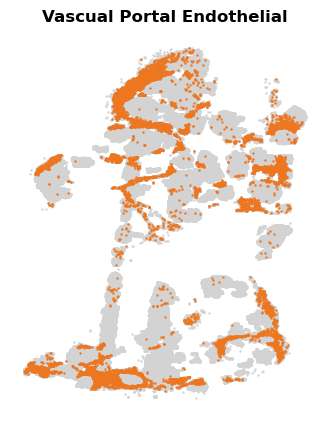

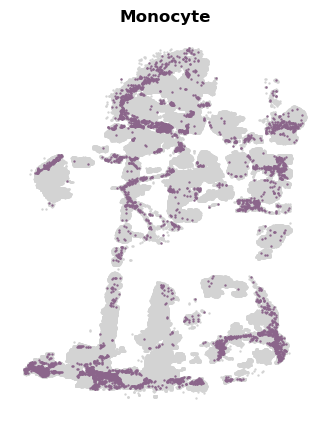

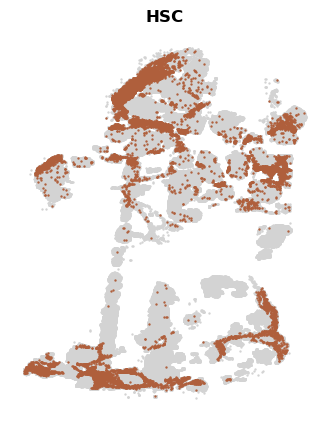

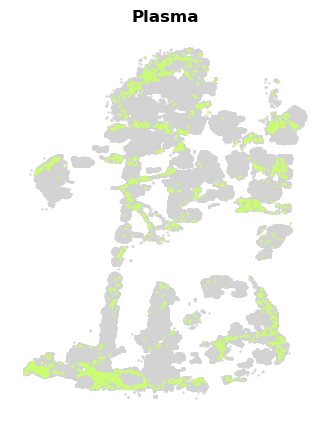

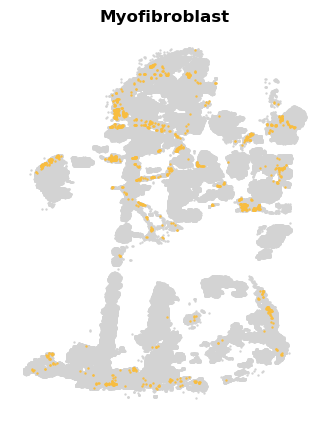

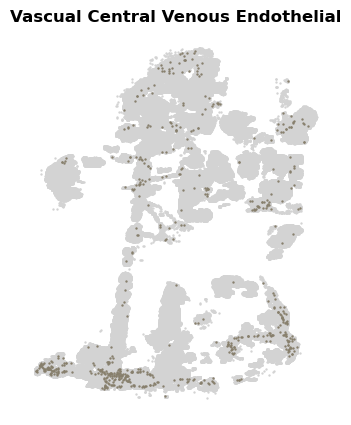

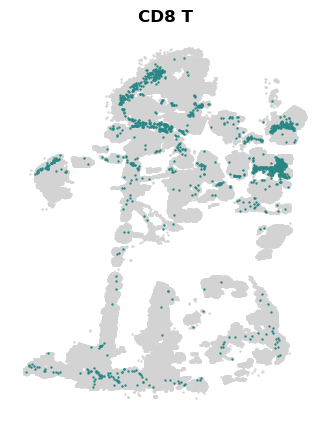

In [16]:
unique_labels = adata.obs['ground_truth'].unique()
label_to_color = {label: plot_color[i] for i, label in enumerate(unique_labels)}
output_dir = "label_plots_pred2_MS19"
os.makedirs(output_dir, exist_ok=True)
for label in unique_labels:
    fig, ax = plt.subplots()

    # Plot all cells in gray
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=0.5)

    # Then, overlay the cells of the current label in their respective color
    label_indices = adata.obs['ground_truth'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=label_to_color[label], s=0.5)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.axis('off')
    safe_label = label.replace("/", "_").replace("\\", "_").replace(":", "_")
    output_file = os.path.join(output_dir, f"{safe_label}.png")
    plt.gca().invert_yaxis()
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

In [ ]:
unique_labels = adata.obs['domain'].unique()
output_dir = "Domain_SemanticST_21_n26"
os.makedirs(output_dir, exist_ok=True)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
           "#877F6C","#268785", '#82EF2D', '#B4EEB4']
label_to_color = {label: plot_color[i] for i, label in enumerate(unique_labels)}

for label in unique_labels:
    fig, ax = plt.subplots()

    # Plot all cells in gray
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=1)

    # Then, overlay the cells of the current label in their respective color
    label_indices = adata.obs['domain'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=label_to_color[label], s=1)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.axis('off')
   # safe_label = label.replace("/", "_").replace("\\", "_").replace(":", "_")
    output_file = os.path.join(output_dir, f"{label}.png")
    plt.gca().invert_yaxis()

    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

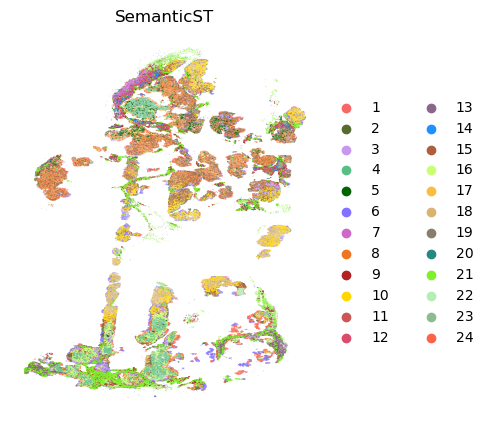

/tmp/ipykernel_24854/1967155197.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


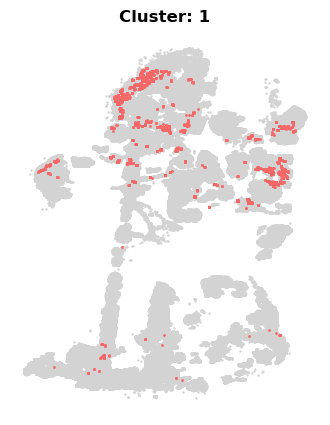

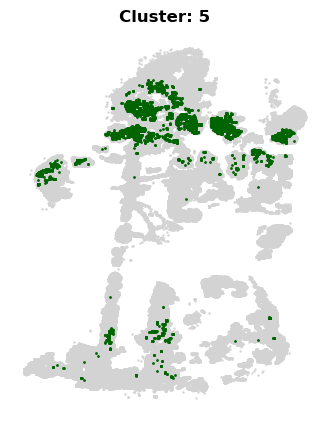

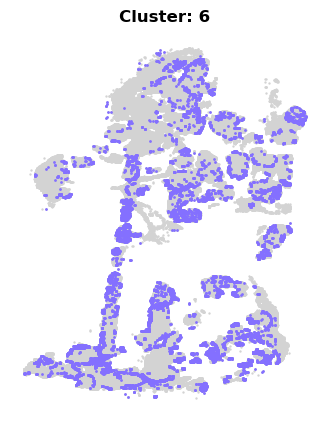

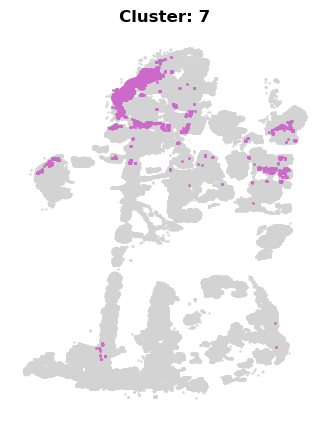

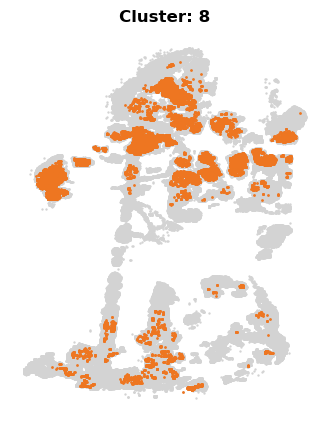

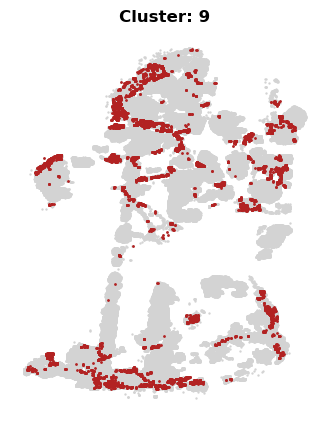

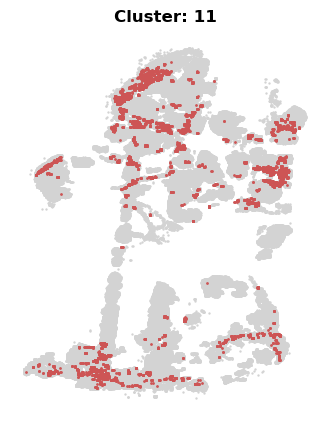

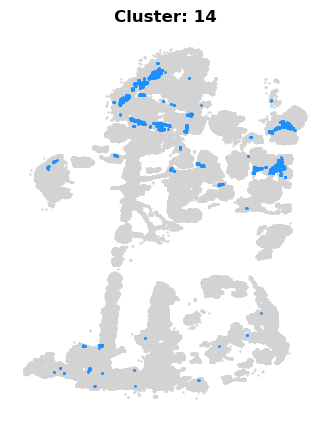

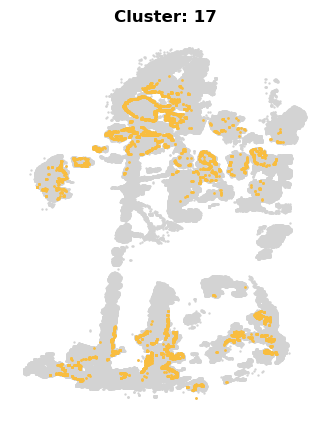

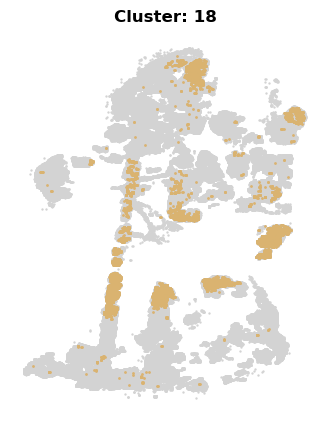

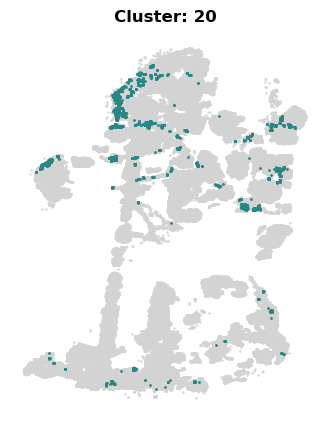

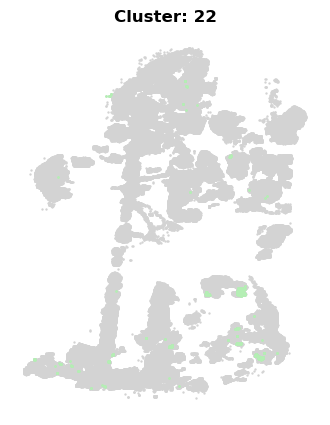

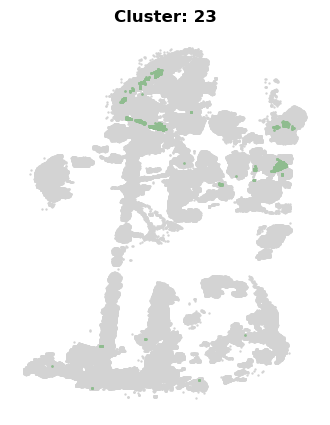

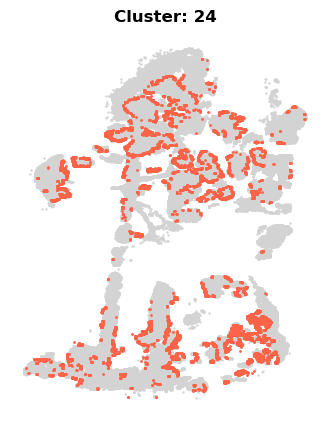

In [24]:
import os
import matplotlib.pyplot as plt
adata.obs['domain'] = adata.obs['domain'].astype('category')
# Set figure size
plt.rcParams["figure.figsize"] = (4, 5)
s=24
d='MS19'
#adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]
# Define colors for clusters
plot_color = [
    "#F56867", "#556B2F", "#C798EE", "#59BE86", "#006400", "#8470FF",
    "#CD69C9", "#EE7621", "#B22222", "#FFD700", "#CD5555", "#DB4C6C",
    "#8B658B", "#1E90FF", "#AF5F3C", "#CAFF70", "#F9BD3F", "#DAB370",
    "#877F6C", "#268785", "#82EF2D", "#B4EEB4", "#8FBC8F", "#FF6347",
    "#9370DB", "#00CED1", "#FF7F50", "#4682B4", "#7B68EE"
]

# Plot all clusters together
sc.pl.embedding(adata, basis="spatial", color="domain", palette=plot_color, show=False, title="SemanticST")
plt.gca().invert_yaxis()  # Invert the y-axis to match the original plot style
plt.axis('off')
plt.savefig(f"SemanticST_{s}_{d}", dpi=300, bbox_inches='tight')
plt.show()

# Create directory to save individual cluster plots
output_dir = f"Domain_SemanticST_{s}_{d}"
os.makedirs(output_dir, exist_ok=True)

# Get unique labels and create consistent color mapping
unique_labels = sorted(adata.obs['domain'].unique())  # Ensure consistent order
label_to_color = {label: plot_color[i] for i, label in enumerate(unique_labels)}

# Plot individual clusters
for label in unique_labels:
    fig, ax = plt.subplots()

    # Plot all cells in gray
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=0.5)

    # Then, overlay the cells of the current label in their respective color
    label_indices = adata.obs['domain'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=label_to_color[label], s=1)

    # Set title and axis
    ax.set_title(f"Cluster: {label}", fontsize=12, fontweight='bold')
    ax.axis('off')

    # Invert y-axis
    plt.gca().invert_yaxis()

    # Save each plot with the corresponding label
    safe_label = str(label).replace("/", "_").replace("\\", "_").replace(":", "_")
    output_file = os.path.join(output_dir, f"{safe_label}.png")
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
   # plt.close(fig)


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20,random_state=1) 
embedding = pca.fit_transform(adata.obsm['emb_decoder'].copy())
adata.obsm['emb_pca'] = embedding

In [5]:
sc.pp.neighbors(adata, use_rep='emb_pca')
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/rokny/miniconda3/envs/semanticST/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sc.tl.leiden(adata, resolution=0.2)

/tmp/ipykernel_6449/4124055652.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


In [11]:
sc.tl.louvain(adata, resolution=0.4)

KeyboardInterrupt: 

/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


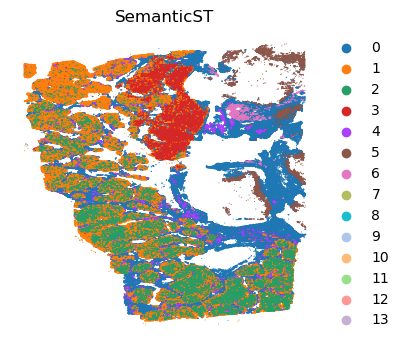

In [27]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=2, show=False, title='SemanticST')
plt.gca().invert_yaxis()

plt.axis('off')
plt.savefig("SemanticST_louvain_n26.png", dpi=300,bbox_inches='tight')

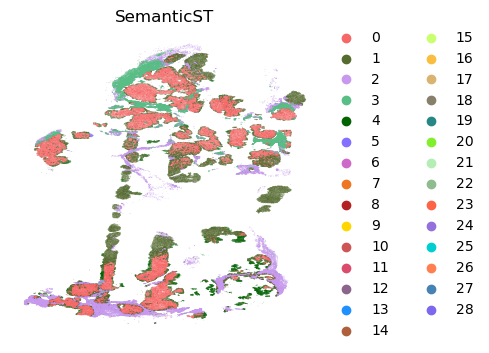

In [9]:
import os
import matplotlib.pyplot as plt
#adata.obs['domain'] = adata.obs['louvain'].astype('category')
#adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]

# Set figure size
plt.rcParams["figure.figsize"] = (4, 4)
s="leiden"
# Define colors for clusters
plot_color = [
    "#F56867", "#556B2F", "#C798EE", "#59BE86", "#006400", "#8470FF",
    "#CD69C9", "#EE7621", "#B22222", "#FFD700", "#CD5555", "#DB4C6C",
    "#8B658B", "#1E90FF", "#AF5F3C", "#CAFF70", "#F9BD3F", "#DAB370",
    "#877F6C", "#268785", "#82EF2D", "#B4EEB4", "#8FBC8F", "#FF6347",
    "#9370DB", "#00CED1", "#FF7F50", "#4682B4", "#7B68EE"
]



# Plot all clusters together
sc.pl.embedding(adata, basis="spatial", color="leiden", palette=plot_color, show=False, title="SemanticST")
plt.gca().invert_yaxis()  # Invert the y-axis to match the original plot style
plt.axis('off')
plt.savefig(f"SemanticST_{s}_MS19", dpi=300, bbox_inches='tight')
plt.show()

# Create directory to save individual cluster plots
output_dir = f"Domain_SemanticST_{s}_MS19"
os.makedirs(output_dir, exist_ok=True)

# Get unique labels and create consistent color mapping
unique_labels = sorted(adata.obs['leiden'].unique())  # Ensure consistent order
label_to_color = {label: plot_color[i] for i, label in enumerate(unique_labels)}

# Plot individual clusters
for label in unique_labels:
    fig, ax = plt.subplots()

    # Plot all cells in gray
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=1)

    # Then, overlay the cells of the current label in their respective color
    label_indices = adata.obs['leiden'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=label_to_color[label], s=1)

    # Set title and axis
    ax.set_title(f"Cluster: {label}", fontsize=12, fontweight='bold')
    ax.axis('off')

    # Invert y-axis
    plt.gca().invert_yaxis()

    # Save each plot with the corresponding label
    safe_label = str(label).replace("/", "_").replace("\\", "_").replace(":", "_")
    output_file = os.path.join(output_dir, f"{safe_label}.png")
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close(fig)


/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


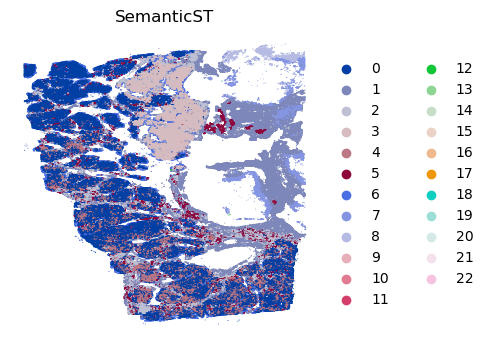

In [28]:
plt.rcParams["figure.figsize"] = (4, 5)
sc.pl.embedding(adata, basis="spatial", color="leiden",s=1, show=False, title='SemanticST_leiden')
plt.gca().invert_yaxis()

plt.axis('off')
plt.savefig("SemanticST_leiden_n26.png", dpi=300,bbox_inches='tight')

/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


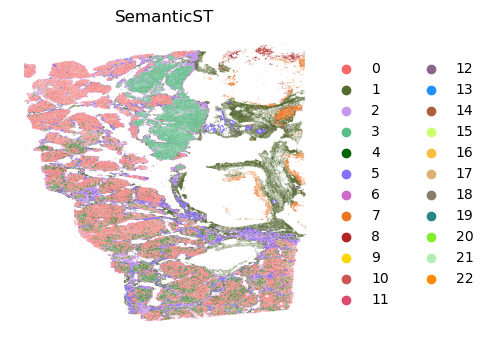

In [43]:
import os
import matplotlib.pyplot as plt
#adata.obs['domain'] = adata.obs['louvain'].astype('category')
# Set figure size
plt.rcParams["figure.figsize"] = (4, 4)
s="leiden"
# Define colors for clusters
plot_color = ["#F56867", "#556B2F", "#C798EE", "#59BE86", "#006400", "#8470FF",
              "#CD69C9", "#EE7621", "#B22222", "#FFD700", "#CD5555", "#DB4C6C",
              "#8B658B", "#1E90FF", "#AF5F3C", "#CAFF70", "#F9BD3F", "#DAB370",
              "#877F6C", "#268785", '#82EF2D', '#B4EEB4']

# Plot all clusters together
sc.pl.embedding(adata, basis="spatial", color="leiden", palette=plot_color, show=False, title="SemanticST")
plt.gca().invert_yaxis()  # Invert the y-axis to match the original plot style
plt.axis('off')
plt.savefig(f"SemanticST_{s}_n26", dpi=300, bbox_inches='tight')
plt.show()

# Create directory to save individual cluster plots
output_dir = f"Domain_SemanticST_{s}_n26"
os.makedirs(output_dir, exist_ok=True)

# Get unique labels and create consistent color mapping
unique_labels = sorted(adata.obs['leiden'].unique())  # Ensure consistent order
label_to_color = {label: plot_color[i] for i, label in enumerate(unique_labels)}

# Plot individual clusters
for label in unique_labels:
    fig, ax = plt.subplots()

    # Plot all cells in gray
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=1)

    # Then, overlay the cells of the current label in their respective color
    label_indices = adata.obs['leiden'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=label_to_color[label], s=1)

    # Set title and axis
    ax.set_title(f"Cluster: {label}", fontsize=12, fontweight='bold')
    ax.axis('off')

    # Invert y-axis
    plt.gca().invert_yaxis()

    # Save each plot with the corresponding label
    safe_label = str(label).replace("/", "_").replace("\\", "_").replace(":", "_")
    output_file = os.path.join(output_dir, f"{safe_label}.png")
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close(fig)


/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


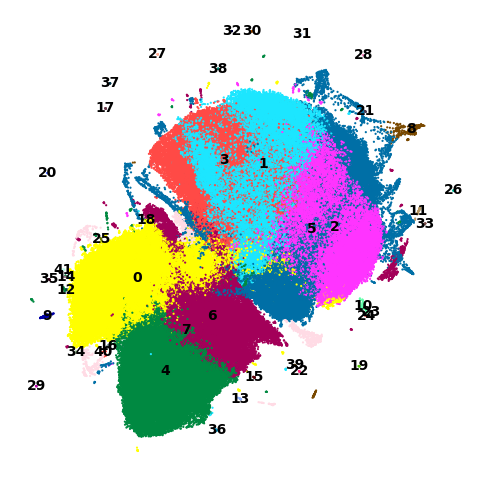

In [45]:
plt.rcParams["figure.figsize"] = (6, 6)
sc.pl.umap(adata, color="leiden",title='', legend_loc='on data', s=10,show=False)
# Get the current figure and axis
fig = plt.gcf()
ax = plt.gca()

# Remove x and y axis labels
ax.set_xlabel('')
ax.set_ylabel('')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Save the plot with 600 DPI
#fig.savefig("umap_plot_Semantic21.png", dpi=600, bbox_inches='tight')
# Display the plot
plt.show()

In [40]:
np.save("domain_louvain.npy",adata.obs['louvain'])

In [24]:
np.save("domain_leiden_n26.npy",adata.obs['leiden'])

In [7]:
adata.obs['domain'] = adata.obs['domain'].astype('category')

In [8]:
sc.tl.rank_genes_groups(adata, "domain", method="wilcoxon")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
import pandas as pd

# Extract the rank_genes_groups results
rank_genes_groups = adata.uns['rank_genes_groups']
groups = rank_genes_groups['names'].dtype.names

# Convert the results to a pandas DataFrame
degs = {
    group: pd.DataFrame({
        'names': rank_genes_groups['names'][group],
        'logfoldchanges': rank_genes_groups['logfoldchanges'][group],
        'pvals_adj': rank_genes_groups['pvals_adj'][group]
    }) for group in groups
}

# Define the log fold change threshold
log_fc_threshold = 1

# Filter for significant DEGs (e.g., adjusted p-value < 0.05 and |logFC| > 1)
sig_degs = {
    group: degs[group][(degs[group]['pvals_adj'] < 0.01) & (abs(degs[group]['logfoldchanges']) > log_fc_threshold)]
    for group in groups
}

# Extract DEG names for each attention score
deg_names = {group: sig_degs[group]['names'].tolist() for group in groups}

# Print DEG names for each attention score
for group, genes in deg_names.items():
    print(f"\nDEGs for {group}:")
    print(genes[:20])  # Print first 20 DEGs for brevity


DEGs for 1:
['VIM', 'BGN', 'CXCL12', 'MMP2', 'CCN2', 'PDGFRA', 'RPS19', 'TAGLN', 'ANXA1', 'ITGB1', 'ITGA9', 'IL6ST', 'ACTA2', 'GSN', 'HGF', 'EGR1', 'HLA-E', 'NRP1', 'VCAN', 'FGFR1']

DEGs for 2:
['CCN2', 'ACTA2', 'TAGLN', 'VIM', 'IGHG3', 'BGN', 'VCAN', 'MMP2', 'THBS2', 'MYH11', 'CD44', 'POSTN', 'GSN', 'MZB1', 'CD79A', 'FAP', 'PLN', 'NOTCH3', 'CD27', 'TPSB2']

DEGs for 3:
['APOB', 'CYP2E1', 'PLG', 'ADH1B', 'CYP2C9', 'FABP1', 'ORM1', 'G6PC', 'FGB', 'CLU', 'VTN', 'APOC2', 'ANG', 'LECT2', 'CFHR5', 'COL18A1', 'AKR1C1', 'FN1', 'DUSP1', 'CDH1']

DEGs for 4:
['CYP2E1', 'IGFBP3', 'CXCL12', 'FABP1', 'FGB', 'ADH1B', 'CYP2C9', 'APOB', 'PLG', 'VTN', 'ORM1', 'BGN', 'HGF', 'APOC2', 'FN1', 'ITGA9', 'CLU', 'PDGFRA', 'CHI3L1', 'FCN3']

DEGs for 5:
['RPS19', 'IL7R', 'CD44', 'HLA-E', 'VIM', 'PTPRC', 'CD3E', 'CCL5', 'SRGN', 'CXCR4', 'BTG1', 'HLA-A', 'ANXA1', 'ATM', 'GZMK', 'TCF7', 'STAT1', 'CCL21', 'GZMA', 'CXCL12']

DEGs for 6:
['FGB', 'CYP2E1', 'ORM1', 'FABP1', 'CYP2C9', 'ADH1B', 'VTN', 'PLG', 'CLU', 'A

In [35]:
import pandas as pd

# Extract the rank_genes_groups results
rank_genes_groups = adata.uns['rank_genes_groups']
groups = rank_genes_groups['names'].dtype.names

# Convert the results to a pandas DataFrame
degs = {
    group: pd.DataFrame({
        'names': rank_genes_groups['names'][group],
        'logfoldchanges': rank_genes_groups['logfoldchanges'][group],
        'pvals_adj': rank_genes_groups['pvals_adj'][group]
    }) for group in groups
}

# Define the log fold change threshold
log_fc_threshold = 1

# Filter for significant DEGs (e.g., adjusted p-value < 0.05 and |logFC| > 1)
sig_degs = {
    group: degs[group][(degs[group]['pvals_adj'] < 0.01) & (abs(degs[group]['logfoldchanges']) > log_fc_threshold)]
    for group in groups
}

# Extract DEG names for each attention score
deg_names = {group: sig_degs[group]['names'].tolist() for group in groups}

# Print DEG names for each attention score
for group, genes in deg_names.items():
    print(f"\nDEGs for {group}:")
    print(genes[:10])  # Print first 20 DEGs for brevity


DEGs for B:
['CD79A', 'MS4A1', 'BANK1', 'CD44', 'PTPN6', 'IGHG3', 'SELL', 'CD19', 'HLA-E', 'VIM']

DEGs for CD4 T:
['IL7R', 'CCL5', 'PTPRC', 'CD44', 'CD3E', 'RPS19', 'HLA-E', 'CXCR4', 'GZMA', 'GZMK']

DEGs for CD8 T:
['CCL5', 'GZMA', 'VIM', 'CD44', 'CCL4', 'PTPRC', 'HLA-E', 'CD3E', 'ACTA2', 'CXCR4']

DEGs for Cholangiocyte:
['CD24', 'SPP1', 'KRT7', 'EPCAM', 'APP', 'GLUL', 'AKR1C1', 'CDH1', 'NOTCH2', 'PROM1']

DEGs for DC2:
['LYZ', 'CD1C', 'SRGN', 'VIM', 'CD44', 'RPS19', 'ITGAX', 'ITGB2', 'ANXA1', 'PTPRC']

DEGs for HSC:
['BGN', 'IGFBP3', 'VIM', 'CCN2', 'CXCL12', 'TAGLN', 'ACTA2', 'HGF', 'PDGFRA', 'IGHG3']

DEGs for Hepatocyte:
['FGB', 'ORM1', 'VTN', 'PLG', 'APOB', 'FABP1', 'CYP2C9', 'CLU', 'APOC2', 'CYP2E1']

DEGs for Inflammatory Macrophage:
['CD68', 'LYZ', 'VIM', 'SPP1', 'SRGN', 'CD44', 'GRN', 'ITGB2', 'LGALS3', 'ITGAX']

DEGs for Monocyte:
['LYZ', 'VIM', 'VCAN', 'SRGN', 'CD44', 'ITGB2', 'FCN1', 'ITGAX', 'CD68', 'IGHG3']

DEGs for Myofibroblast:
['ACTA2', 'TAGLN', 'VIM', 'MYH11', 'C

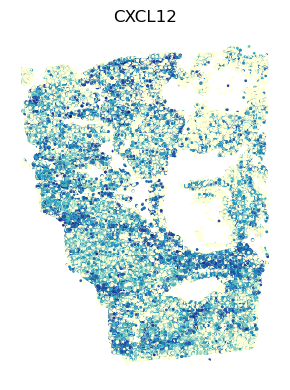

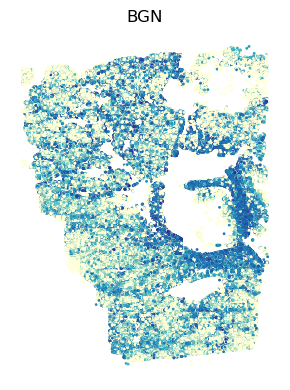

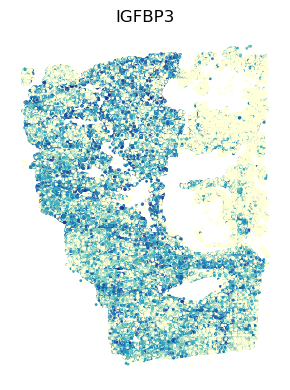

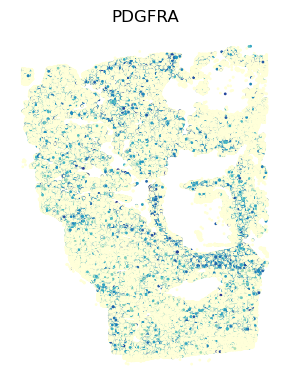

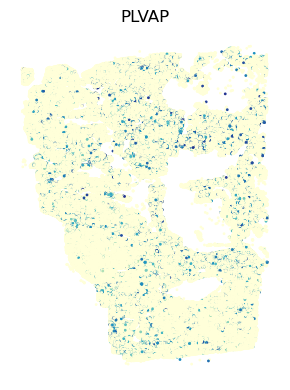

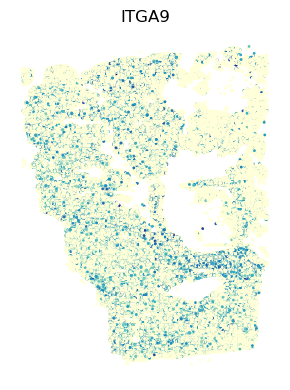

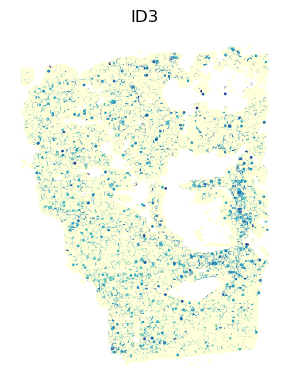

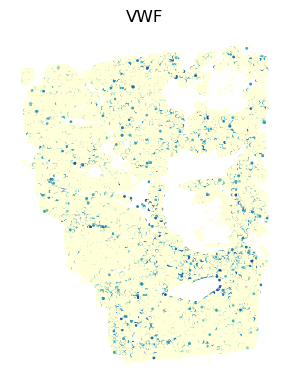

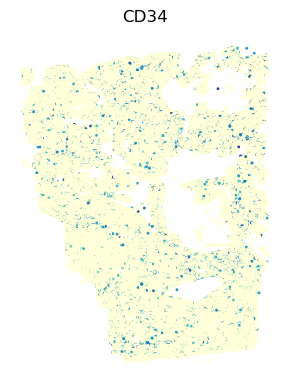

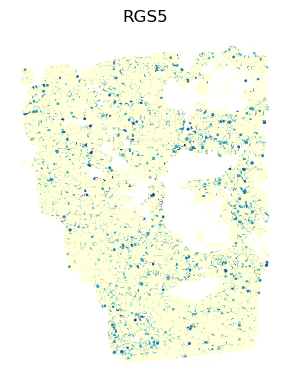

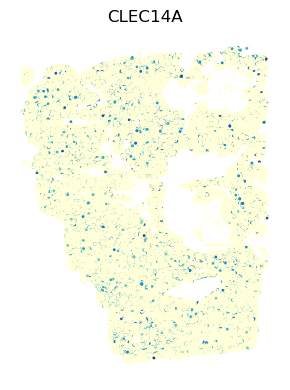

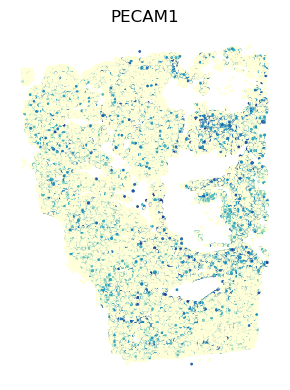

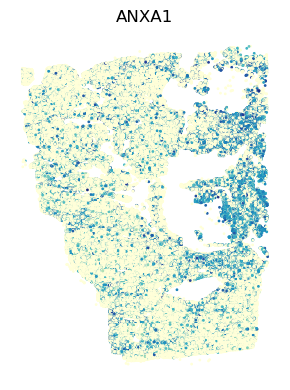

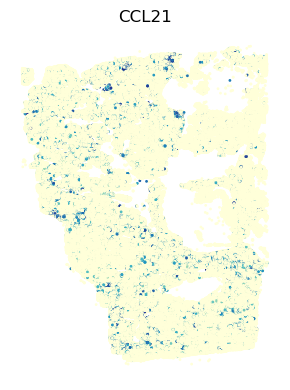

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

#adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]
G=['MS4A1','PLG']

G3=['FABP1','SOX5','MARCO','CD24','FRG1','VIM','COL18A1','SRGN','MS4A1','PLG']
G2 =['CXCL12', 'BGN', 'IGFBP3', 'VIM', 'APP', 'HGF', 'PDGFRA', 'GSN', 'PLVAP', 'ITGB1', 'ITGA9', 'ID3', 'NRP1', 'VWF', 'CD34', 'RGS5', 'CLEC14A', 'PECAM1', 'ANXA1', 'CCL21']
lofg = adata.var['gene_ids'].index

# Ensure the gene is in the dataset
for gene in G2:
    # Extract the expression values for the gene
    afp_expression = adata[:, gene].X

    # If the data is stored as a sparse matrix, convert it to a dense array
    if issparse(afp_expression):
        afp_expression = afp_expression.toarray().flatten()
    else:
        afp_expression = afp_expression.flatten()

    # Apply Min-Max Normalization
    min_exp = afp_expression.min()
    max_exp = afp_expression.max()

    if max_exp > min_exp:
        afp_expression_normalized = (afp_expression - min_exp) / (max_exp - min_exp)
    else:
        afp_expression_normalized = afp_expression  # If min == max, normalization is not needed

    # Create the scatter plot using matplotlib
    plt.figure(figsize=(3,4))
    plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
                c=afp_expression_normalized, cmap='YlGnBu', s=1)
    plt.title(gene)
    plt.axis('off')

    # Add a colorbar to indicate the expression level
    #plt.colorbar(label='Expression Level')
    plt.tight_layout()
  #  plt.savefig(f"paper_genes_n26/{gene}.png", dpi=300, bbox_inches='tight')
    plt.show()
  #  plt.close()


In [ ]:
 # Apply Min-Max Normalization
    min_exp = afp_expression.min()
    max_exp = afp_expression.max()

    if max_exp > min_exp:
        afp_expression_normalized = (afp_expression - min_exp) / (max_exp - min_exp)
    else:
        afp_expression_normalized = afp_expression  # If min == max, normalization is not needed

In [30]:
# Extract the gene names (index of the gene_ids Series)
gene_names = adata.var['gene_ids'].index

# Save the gene names as a text file with each gene name on a new line
with open('gene_names.txt', 'w') as f:
    for gene_name in gene_names:
        f.write(f"{gene_name}\n")




In [17]:
import pandas as pd
import numpy as np

# Get the unique clusters and annotations
unique_clusters = adata.obs['domain'].unique()
unique_annotations = adata.obs['ground_truth'].unique()

# Initialize a DataFrame to store similarity percentages
similarity_matrix = pd.DataFrame(index=unique_annotations, columns=unique_clusters, data=0.0)

# Iterate over each annotation
for annotation in unique_annotations:
    # Get the indices of the cells belonging to the current annotation
    annotation_indices = adata.obs.index[adata.obs['ground_truth'] == annotation]
    
    # Get the cluster labels for these cells
    clusters = adata.obs.loc[annotation_indices, 'domain']
    
    # Calculate the percentage of cells from this annotation that are in each cluster
    cluster_counts = clusters.value_counts()
    total_count = len(clusters)
    for cluster, count in cluster_counts.items():
        similarity_matrix.loc[annotation, cluster] = (count / total_count) * 100

# Print the similarity matrix
print(similarity_matrix)

# Print the highest percentage cluster for each annotation
for annotation in unique_annotations:
    highest_cluster = similarity_matrix.loc[annotation].idxmax()
    highest_percentage = similarity_matrix.loc[annotation].max()
    print(f"Annotation {annotation}: Most Frequent Cluster - {highest_cluster} ({highest_percentage:.2f}%)")

# Save the results back into adata for future use
adata.uns['annotation_similarity_matrix'] = similarity_matrix


                                            4          6        15         17  \
Hepatocyte                           9.044385  18.663540  2.952254   0.217726   
Sinusoidal Endothelial              26.350455   8.473826  8.473826   1.184566   
Vascual Portal Endothelial           1.225264   0.108430  9.685552  20.734616   
Portal Fibroblast                    3.815155   0.370632  4.326980   5.194729   
Monocyte                             1.058099   0.211620  1.115814   2.327818   
HSC                                  1.319381   0.195365  5.269496   2.986672   
CD4 T                                2.400235   1.544641  1.975704   2.472079   
DC2                                  1.715854   0.137268  2.814001   3.912148   
Inflammatory Macrophage              0.675173   0.079745  0.536948   0.792132   
Cholangiocyte                        0.949796   0.294764  3.097366   0.407056   
Noninflammatory Macrophage           7.286251   4.137782  2.289139   0.924321   
NK                          

In [27]:
adata.obs['ground_truth']

aaaadkjh-1                    Hepatocyte
aaaagijo-1                    Hepatocyte
aaaajceb-1                         CD4 T
aaaakbjo-1                    Hepatocyte
aaaamafg-1                    Hepatocyte
                         ...            
oiklpbed-1                    Hepatocyte
oikmcmog-1                    Hepatocyte
oikmdfli-1    Noninflammatory Macrophage
oikmeoka-1                         CD4 T
oikmepmj-1                    Hepatocyte
Name: ground_truth, Length: 316350, dtype: category
Categories (21, object): ['B', 'CD4 T', 'CD8 T', 'Cholangiocyte', ..., 'Sinusoidal Endothelial', 'Vascual Central Venous Endothelial', 'Vascual Portal Endothelial', 'pDC']

In [29]:
 adata.var['gene_ids'].index

Index(['ACKR1', 'ACTA2', 'ACVR2A', 'ADAM17', 'ADAM9', 'ADH1B', 'AFP', 'AKR1C1',
       'ANG', 'ANXA1',
       ...
       'VEGFC', 'VIM', 'VTN', 'VWF', 'XCL1', 'XCL2', 'YARS', 'ZBTB20', 'ZEB1',
       'ZNF683'],
      dtype='object', length=319)

In [16]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="domain", standard_scale="var", n_genes=20,dendrogram=False,save='.pdf'
)

KeyError: 'rank_genes_groups'

In [32]:
unique_annotations = adata.obs['ground_truth'].unique()

In [33]:
unique_annotations

['Hepatocyte', 'Sinusoidal Endothelial', 'Vascual Portal Endothelial', 'Portal Fibroblast', 'Monocyte', ..., 'Plasma', 'Myofibroblast', 'pDC', 'NK_CD56bright', 'Vascual Central Venous Endothelial']
Length: 20
Categories (20, object): ['B', 'CD4 T', 'CD8 T', 'Cholangiocyte', ..., 'Sinusoidal Endothelial', 'Vascual Central Venous Endothelial', 'Vascual Portal Endothelial', 'pDC']

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a small figure for the color bar
fig, ax = plt.subplots(figsize=(2, 4))  # Adjust figsize to make it small

# Create a dummy mappable object with a colormap
cmap = plt.cm.get_cmap('YlGnBu')
norm = plt.Normalize(vmin=0, vmax=1)

# Create a colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

# Set the title for the colorbar
cbar.set_label('Expression', fontsize=10)

# Remove axis ticks and labels to make it cleaner
ax.set_axis_off()

# Save the colorbar to a file
plt.savefig('expression_colorbar_2.png', dpi=300, bbox_inches='tight')

# Optionally, show the colorbar
plt.show()


/tmp/ipykernel_92678/975305635.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu')


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

#adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]
G=['MS4A1','PLG']
G_19 = ["SPP1", "GLUL", "CYP2E1", "IGHG3", "G6PC", "FN1", "HULC", "CCL21", "FGB", "OCLN", "COL18A1", "HLA-E", "MYH11", "HMGB1", "MS4A1"]

G3=['FABP1','SOX5','MARCO','CD24','FRG1','VIM','COL18A1','SRGN','MS4A1','PLG']
G2 =['CXCL12', 'BGN', 'IGFBP3', 'VIM', 'APP', 'HGF', 'PDGFRA', 'GSN', 'PLVAP', 'ITGB1', 'ITGA9', 'ID3', 'NRP1', 'VWF', 'CD34', 'RGS5', 'CLEC14A', 'PECAM1', 'ANXA1', 'CCL21']
lofg = adata.var['gene_ids'].index

# Ensure the gene is in the dataset
for gene in G_19:
    # Extract the expression values for the gene
    afp_expression = adata[:, gene].X

    # If the data is stored as a sparse matrix, convert it to a dense array
    if issparse(afp_expression):
        afp_expression = afp_expression.toarray().flatten()
    else:
        afp_expression = afp_expression.flatten()

    # Apply Min-Max Normalization
    min_exp = afp_expression.min()
    max_exp = afp_expression.max()

    if max_exp > min_exp:
        afp_expression_normalized = (afp_expression - min_exp) / (max_exp - min_exp)
    else:
        afp_expression_normalized = afp_expression  # If min == max, normalization is not needed

    # Create the scatter plot using matplotlib
    plt.figure(figsize=(3,4))
    plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
                c=afp_expression_normalized, cmap='YlGnBu', s=1)
    plt.title(gene)
    plt.axis('off')

    # Add a colorbar to indicate the expression level
    #plt.colorbar(label='Expression Level')
    plt.tight_layout()
    plt.savefig(f"paper_genes_ms19/{gene}.png", dpi=300, bbox_inches='tight')
    plt.show()
  #  plt.close()


NameError: name 'adata' is not defined